In [260]:
#Import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from random import sample
import random
import gmaps
import folium
pd.options.display.max_seq_items = 2000
np.set_printoptions(threshold=np.nan)

# Google developer API key
from config import gkey
# Configure gmaps
gmaps.configure(api_key=gkey)

%matplotlib inline

In [199]:
#Read Raw Data

df=pd.read_csv('DataClean\\NivelSatisf1Clean.csv',encoding='utf-8',low_memory=False)

In [200]:
# Homologates the names of MedicalUnits by merging the original data set with a new data frame with MedicalUnits unique values

df2=df[['Id_Unidad','Unidmed']]
df3=pd.DataFrame(df2.groupby('Id_Unidad').Unidmed.first())
df5=df3.reset_index()
df5=df5.rename(columns={'Unidmed':'UnidadMed'})
df6=df.merge(df5,how='left',on='Id_Unidad')

In [201]:
df6.head(2)

,Amable,Antescita,Anticoncepe,Anticoncepp,Autortactop,Btratou,Btratou2,Btratou_Mot1,Btratou_Mot2,Btratou_Mot3,...,address,locality,Servatn_cat,Tipopac_cat,Sat1_cat,Sat1_ordered,Sat1_Mot1_cat,Probsal_cat,Date,UnidadMed
0,1.0,1.0,1.0,NaN,NaN,2,NaN,NaN,NaN,NaN,...,"Blvd. Jose Maria Chavez 1202, Lindavista, 2027...",Aguascalientes,Consulta médica,Mayor de edad,Muy Satisfecho,5.0,NaN,Embarazo,2018-10-31,UMF 1 Aguascalientes
1,1.0,1.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,...,"Blvd. Jose Maria Chavez 1202, Lindavista, 2027...",Aguascalientes,Consulta médica,Mayor de edad,Satisfecho,4.0,NaN,Enfermedades del corazón,2018-10-31,UMF 1 Aguascalientes


# Surveys distribution

### The surveys are well distribuited along the main states of the country
### Although statistical test for sample significance is required, this distribution could lead us to think that the resultscould be considered statisticaly significant for the Mexian population

In [202]:
# Build Geocoded Summary Data Frame

dfGeo=df6[['Date',
           'Entidad',
           'UnidadMed',
           'Fecha_D',
           'Fecha_M',
           'Fecha_A',
           'Servatn_cat',
           'Tipopac_cat',
           'Sat1_ordered',
           'Sat1_cat',
           'Probsal',
           'lat',
           'lng']]



encuestas=dfGeo.groupby('Entidad').Entidad.count()
latitud=dfGeo.groupby('Entidad').lat.first()
longitud=dfGeo.groupby('Entidad').lng.first()
sat=dfGeo.groupby('Entidad').Sat1_ordered.mean()

dfGeocode=pd.DataFrame({'encuestas':encuestas,
                        'lat':latitud,
                        'lon':longitud,
                        'satisf':sat                      
                       })

dfGeocode.reset_index(inplace=True)

In [203]:
# Build map with the distribution of the surveys

m = folium.Map(location=[20,-90], tiles="Mapbox Bright", zoom_start=4)
for i in range(0,len(dfGeocode)):
      folium.Circle(location=[dfGeocode.iloc[i]['lat'],dfGeocode.iloc[i]['lon']],
                    popup=(dfGeocode.iloc[i]['Entidad']),
                    radius=float(dfGeocode.iloc[i]['encuestas'])*5,
                    color='crimson',
                    fill=True,
                    fill_color='crimson'
                    ).add_to(m)
        
#Display the map
m

In [204]:
#Save the map
m.save('DataExploring\BubblemapEncuestas.html')

### Age Distribution

### This section shows the age of the people that took the survey

In [205]:
df6['Edad_cat']=df6['Edad_C'].map({1:'18-25',
                                   2:'26-34',
                                   3:'35-44',
                                   4:'45-54',
                                   5:'55-64',
                                   6:'65+'
                                  })
max_age=df6['Edad'].max()

df6['AgeBins']=pd.cut(df6['Edad'],
                       bins=[18,25,34,44,54,64,max_age+1],
                       labels=['18-25','25-34','35-44','45-54','55-64','65+'],
                       include_lowest=True,
                       right=False
                       )

byAge=df6['AgeBins'].dropna()

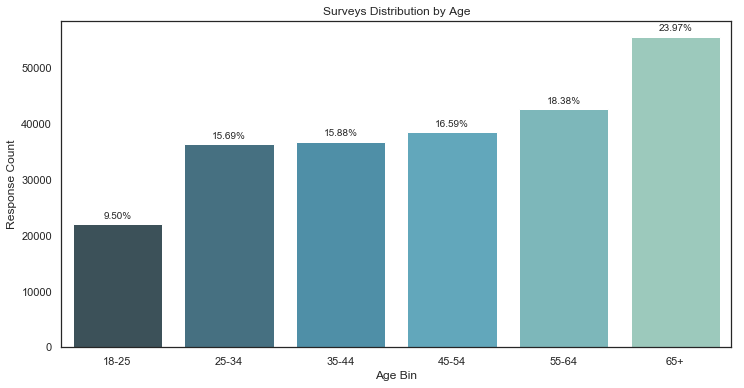

In [234]:
plt.figure(figsize=(12,6))


axAge=sns.countplot(x=byAge,palette=sns.set_palette("GnBu_d")) 


plt.xticks(rotation=0)
total = float(len(byAge)) 

for p in axAge.patches:
        
    height = p.get_height()
    axAge.text(p.get_x()+p.get_width()/2.,height+1000,
            '{:1.2f}%'.format((height/total)*100),
            ha="center")
    
plt.title('Surveys Distribution by Age')
plt.ylabel('Response Count')
plt.xlabel('Age Bin')
plt.show()
fig=axAge.get_figure()
fig.savefig('DataExploring\\AgeDistribution.png',dpi=1200)

### Gender Distribution

In [207]:
df6['Sexo']=df6['Sexo'].map({1:'Mujer',
                             2:'Hombre'
                             })

In [208]:
byGender=pd.DataFrame(df6['Sexo'].dropna().value_counts())

In [209]:
byGender['genderSize']=(byGender['Sexo']/byGender['Sexo'].sum())*100


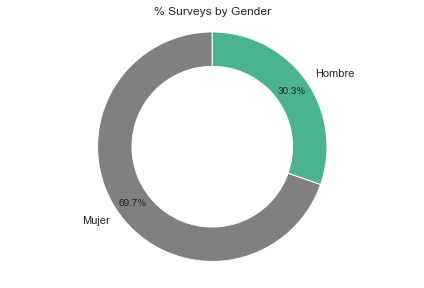

In [263]:
# Build Pie Chart

#explode = (0.02,0.02)



rides_pie=plt.pie(x= byGender['genderSize'],
                  autopct='%1.1f%%',
                  startangle=90, 
                  pctdistance=0.85,
                  colors=('grey',"#4CB391"),
                  labels=['Mujer','Hombre'])


#draw center circle to create donut chart (this is not necesary but I think it looks cleaner)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equals the axis to ensure a circular figure

plt.tight_layout()
plt.axis('equal')
plt.title('% Surveys by Gender')

plt.show()
# Save Figure
plt.savefig('DataExploring\\GenderDistribution.png',dpi=1200)

### Distribution by Education Level

In [211]:
df6['Escolar_cat']=df6['Escolar'].map({1:'Ninguno',
                                       2:'Primaria_incompleta',
                                       3:'Primaria_completa',
                                       4:'Secundaria_incompleta',
                                       5:'Secundaria_completa',
                                       6:'PreparatoriaBachilleratoTecnicoIncompleto',
                                       7:'PreparatoriaBachilleratoTecnicoCompleto',
                                       8:'UniversidadIncompleta',
                                       9:'UniversidadCompletaoMas',
                                       99: np.nan
                                      })

In [212]:
byEdLevel=df6['Escolar_cat'].dropna()

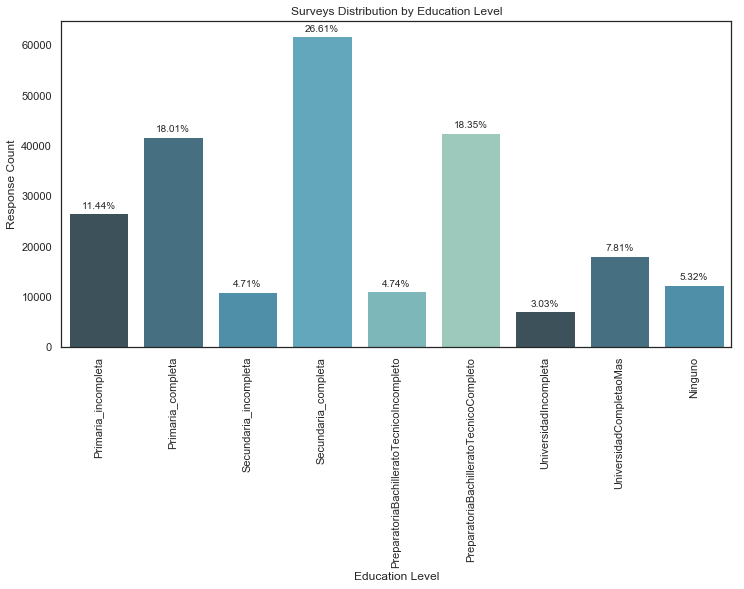

In [264]:
plt.figure(figsize=(12,6))

axEdLevel=sns.countplot(x=byEdLevel,
                        order=['Primaria_incompleta',
                                          'Primaria_completa',
                                          'Secundaria_incompleta',
                                          'Secundaria_completa',
                                          'PreparatoriaBachilleratoTecnicoIncompleto',
                                          'PreparatoriaBachilleratoTecnicoCompleto',
                                          'UniversidadIncompleta',
                                          'UniversidadCompletaoMas',
                                          'Ninguno'],
                        palette =sns.color_palette("GnBu_d"))

plt.xticks(rotation=90)
total = float(len(byEdLevel)) 

for p in axEdLevel.patches:
        
    height = p.get_height()
    axEdLevel.text(p.get_x()+p.get_width()/2.,height+1000,
            '{:1.2f}%'.format((height/total)*100),
            ha="center")
    
plt.title('Surveys Distribution by Education Level')
plt.ylabel('Response Count')
plt.xlabel('Education Level')
plt.show()
fig=axEdLevel.get_figure()
fig.savefig('DataExploring\\EdLevelDistribution.png',dpi=1200)

### Surveys Distribution by Ocupation

In [142]:
df6['Ocupa']=df6['Ocupa'].map({1:'Trabajador por cuenta propia',
                               2:'Sector privado (No maestro)',
                               3:'Sector agropecuario',
                               4:'Obrero',
                               5:'Actividades de su hogar',
                               6:'Estudiante',
                               7:'Maestro',
                               8:'Desempleado',
                               9:'Pensionado o jubilado',
                               10:'Sector público (No maestro)',
                               11:'Trabajadora doméstica',
                               12:'Empleado',
                               13:'Profesionista',
                               14:'Religioso',
                               15:'Pescador / Marinero',
                               16:'Incapacidad',
                               17:'Persona con discapacidad',
                               999:np.nan,
                               })

In [143]:
byOcup=df6['Ocupa'].dropna()

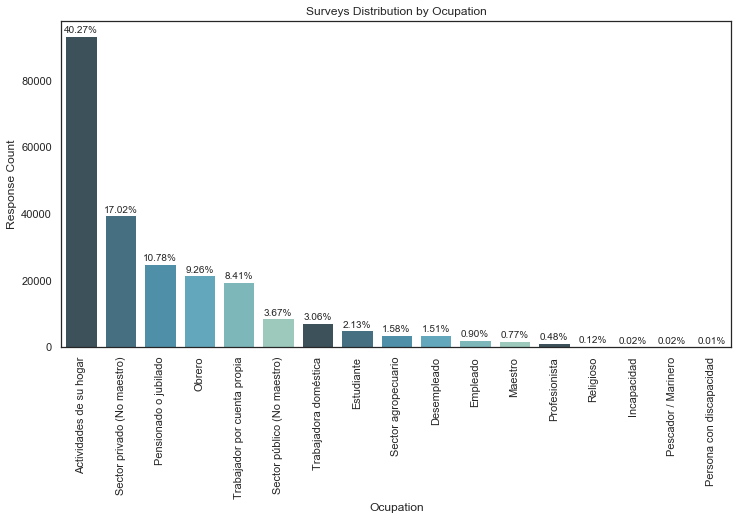

In [218]:
plt.figure(figsize=(12,6))
sns.set_palette("GnBu_d")

axOcup=sns.countplot(x=byOcup,order = byOcup.value_counts().index,palette =sns.color_palette("GnBu_d"))

plt.xticks(rotation=90)
total = float(len(byOcup)) 

for p in axOcup.patches:
        
    height = p.get_height()
    axOcup.text(p.get_x()+p.get_width()/2.,height+1000,
            '{:1.2f}%'.format((height/total)*100),
            ha="center")
    
plt.title('Surveys Distribution by Ocupation')
plt.ylabel('Response Count')
plt.xlabel('Ocupation')
plt.show()
fig=axOcup.get_figure()
fig.savefig('DataExploring\\OcupationDistribution.png',dpi=1200)

# Health Problem Distribution

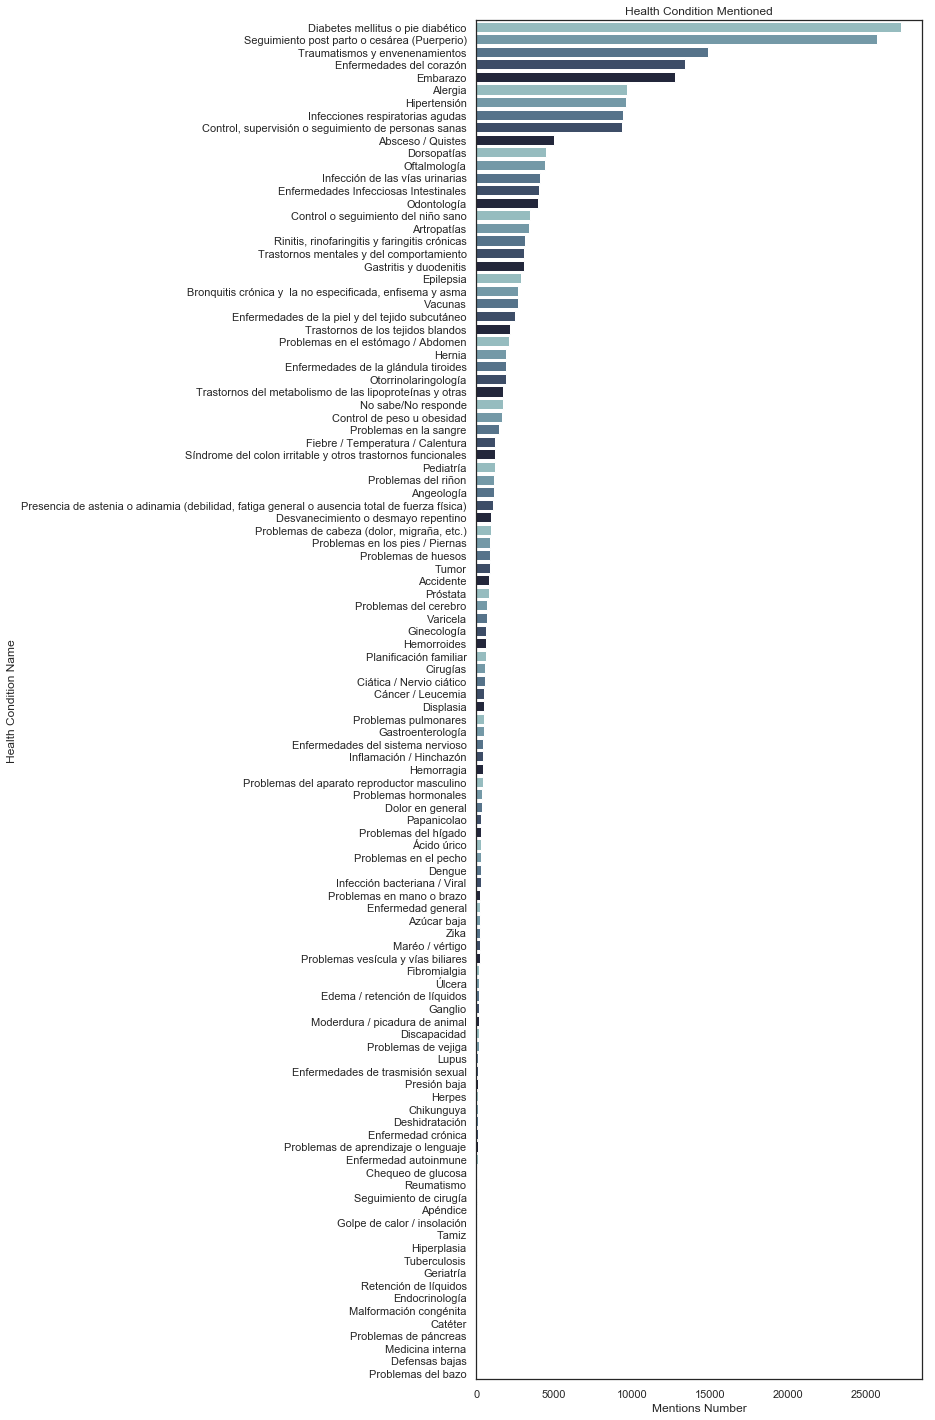

In [292]:
plt.figure(figsize=(8,25))
ax_probl=sns.countplot(y='Probsal_cat',data=df6,order = df6.Probsal_cat.value_counts().index,palette=sns.cubehelix_palette(5, rot=-.25, light=.7))
plt.xlabel('Mentions Number')
plt.ylabel('Health Condition Name')
plt.title('Health Condition Mentioned')
plt.show()
fig=ax_probl.get_figure()
fig.savefig('DataExploring\\ProblSalud.png',dpi=1200)

# Satisfaction Index

In [145]:
# Build Satisfaction Data Frame

df_sat=df6[['Date',
           'Entidad',
           'UnidadMed',
           'Fecha_D',
           'Fecha_M',
           'Fecha_A',
           'Servatn_cat',
           'Tipopac_cat',
           'Sat1_ordered',
           'Sat1_cat',
           'Probsal']]

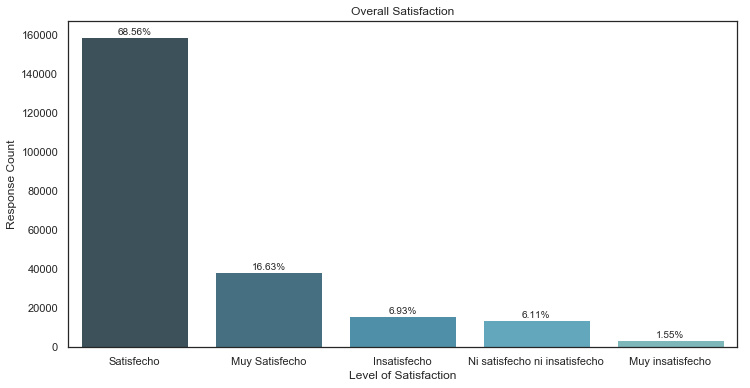

In [219]:
plt.figure(figsize=(12,6))

#build the plot
axOA=sns.countplot(x='Sat1_cat', data=df6,order = df6.Sat1_cat.value_counts().index,palette =sns.color_palette("GnBu_d")) 

plt.xticks(rotation=0)

total = float(len(df6.Sat1_cat)) 

for p in axOA.patches:
        
    height = p.get_height()
    axOA.text(p.get_x()+p.get_width()/2.,height + 1000,
            '{:1.2f}%'.format((height/total)*100),
            ha="center")
    
plt.title('Overall Satisfaction')
plt.ylabel('Response Count')
plt.xlabel('Level of Satisfaction')
plt.show()
fig=axOA.get_figure()
fig.savefig('DataExploring\\fig1OverallSatisfaction.png',dpi=1200)

# Satisfaction level by year

In [170]:
df6.groupby('Fecha_A').Sat1_ordered.mean()

Fecha_A
2017    3.893788
2018    3.943249
Name: Sat1_ordered, dtype: float64

In [176]:
sat_lev_18=df6[df6['Fecha_A']==2018].Sat1_cat.value_counts()

In [177]:
sat_lev_17=df6[df6['Fecha_A']==2017].Sat1_cat.value_counts()

In [178]:
satLevlbyYear=pd.DataFrame({'2018_count':sat_lev_18,
                           '2017_count':sat_lev_17
                           })

In [179]:
satLevlbyYear

,2017_count,2018_count
Satisfecho,74177,85187
Muy Satisfecho,17629,21025
Insatisfecho,8027,8081
Ni satisfecho ni insatisfecho,7568,6637
Muy insatisfecho,1871,1729


In [180]:
satLevlbyYear['2018']=((satLevlbyYear['2018_count']/satLevlbyYear['2018_count'].sum())*100)

In [181]:
satLevlbyYear['2017']=((satLevlbyYear['2017_count']/satLevlbyYear['2017_count'].sum())*100)

In [182]:
satLevlbyYear

,2017_count,2018_count,2018,2017
Satisfecho,74177,85187,69.450265,67.882898
Muy Satisfecho,17629,21025,17.141017,16.133136
Insatisfecho,8027,8081,6.588184,7.345889
Ni satisfecho ni insatisfecho,7568,6637,5.410936,6.925836
Muy insatisfecho,1871,1729,1.409599,1.712241


In [183]:
satLevlbyYear.reset_index(inplace=True)

In [184]:
dfsat=satLevlbyYear[['index','2018','2017']]

In [185]:
dfsat=pd.melt(dfsat,id_vars=['index'],value_vars=['2018','2017'],var_name='Year',value_name='satisf')

In [232]:
dfsat

,index,Year,satisf
0,Satisfecho,2018,69.450265
1,Muy Satisfecho,2018,17.141017
2,Insatisfecho,2018,6.588184
3,Ni satisfecho ni insatisfecho,2018,5.410936
4,Muy insatisfecho,2018,1.409599
5,Satisfecho,2017,67.882898
6,Muy Satisfecho,2017,16.133136
7,Insatisfecho,2017,7.345889
8,Ni satisfecho ni insatisfecho,2017,6.925836
9,Muy insatisfecho,2017,1.712241


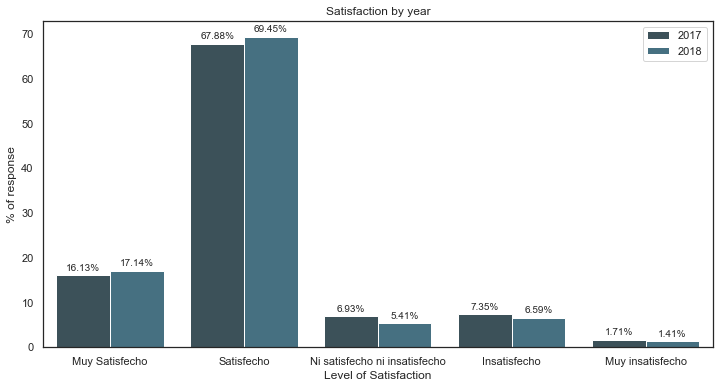

In [251]:
plt.figure(figsize=(12,6))

axbyYr=sns.barplot(x="index",
                  y='satisf',
                  hue='Year',
                  data=dfsat,
                  order=['Muy Satisfecho','Satisfecho','Ni satisfecho ni insatisfecho','Insatisfecho','Muy insatisfecho'],
                  palette =sns.color_palette("GnBu_d")
                  )

for p in axbyYr.patches:
        
    height = p.get_height()
    axbyYr.text(p.get_x()+p.get_width()/2.,
                height + 1,
                '{:1.2f}%'.format(height),
                ha="center")
    

legend=plt.legend(shadow=False)
legend.get_frame().set_facecolor('white')
plt.title('Satisfaction by year')
plt.ylabel('% of response')
plt.xlabel('Level of Satisfaction')
plt.show()
fig=axbyYr.get_figure()
fig.savefig('DataExploring\\fig1Satisfaction17vs18.png',dpi=1200)

# Mean Satisfaction Simulation by Year

In [236]:
dfbyYr=pd.DataFrame(df_sat.groupby(['Entidad','Fecha_A']).Sat1_ordered.mean())

dfYrSt=dfbyYr.reset_index()
avSat17=df_sat[df_sat['Fecha_A']==2017].Sat1_ordered.reset_index(drop=True)
avSat18=df_sat[df_sat['Fecha_A']==2018].Sat1_ordered.reset_index(drop=True)

In [237]:

random.seed(500)
satYrRnd=pd.DataFrame({'2017':sample(list(avSat17),100000),
                      '2018': sample(list(avSat18),100000)})

In [238]:
avsim17=[]
avsim18=[]

random.seed(500)

for i in range(800):

        satYrRnd=pd.DataFrame({'2017':sample(list(avSat17),100000),
                               '2018': sample(list(avSat18),100000)
                              })
        
        avsim17.append(satYrRnd['2017'].mean())
        avsim18.append(satYrRnd['2018'].mean())

<Figure size 576x576 with 0 Axes>

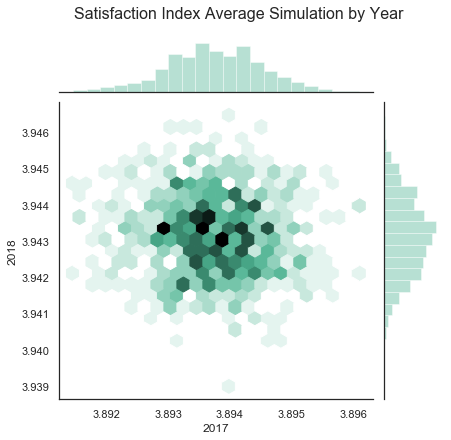

In [268]:
plt.figure(figsize=(8,8))
axyr=sns.jointplot(x=avsim17,y=avsim18,kind='hex',color="#4CB391")

axyr.set_axis_labels("2017", "2018")
plt.subplots_adjust(top=0.9)
plt.suptitle('Satisfaction Index Average Simulation by Year', fontsize=16)
axyr.savefig('DataExploring\\AverageSat17vs18.png',dpi=1200)

plt.show()

# Statistical test for identical means

## Null hypotesis: the two years have identical satisfaction index average

###  We will use the Students-T test for identical means:If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

#     https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [269]:
sample17=np.array(satYrRnd['2017'].dropna())

In [270]:
sample18=np.array(satYrRnd['2018'].dropna())

In [271]:
t2, p2=scipy.stats.ttest_ind(sample17,sample18, equal_var=False)

In [272]:
print("t Statistic = " + str(t2))
print("p-value = " + str(2*p2))

t Statistic = -14.104992911752822
p-value = 7.440385092488949e-45


### As the p-value is very small we can reject the Null hypothesis.
### This means that actually the satisfaction for each year is statistically different and we can conclude it has grown from 2017 to 2018

# Satisfaction Level by State

In [274]:
dfbyState=pd.DataFrame(df_sat.groupby(['Entidad']).Sat1_ordered.mean())

In [275]:
dfbyState.reset_index(inplace=True)

In [276]:
dfbyState.head()

,Entidad,Sat1_ordered
0,Aguascalientes,3.911780
1,Baja California,4.047844
2,Baja California Sur,4.035744
3,Campeche,3.781414
4,Chiapas,3.994561


In [277]:
dfbyState.sort_values(by=['Sat1_ordered'],ascending=False,inplace=True)

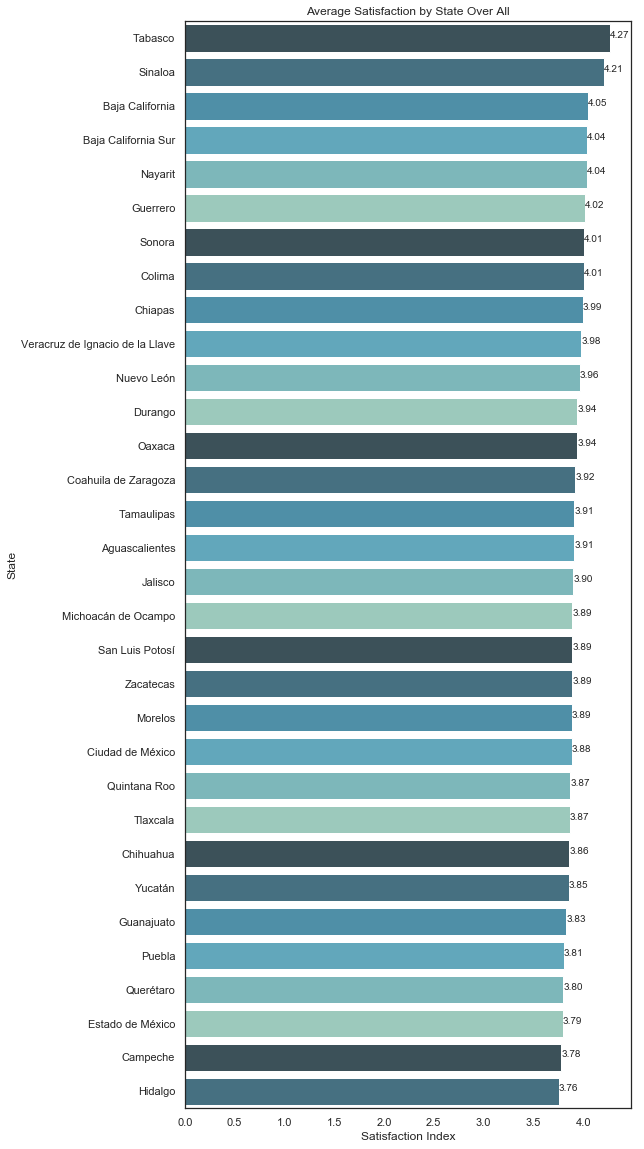

In [278]:
sns.set_palette("RdBu_r")
plt.figure(figsize=(8,20))
ax_st=sns.barplot(x="Sat1_ordered", 
                  y="Entidad",
                  data=dfbyState,
                  label="Total",
                  palette =sns.color_palette("GnBu_d"))

for p in ax_st.patches:   
    height = p.get_height()
    ax_st.text(p.get_width()+.1, p.get_y() + p.get_height()/2.,
               s='{:1.2f}'.format(p.get_width()),
               ha="center")
    
plt.title('Average Satisfaction by State Over All')
plt.ylabel('State')
plt.xlabel('Satisfaction Index')
plt.show()
fig=ax_st.get_figure()
fig.savefig('DataExploring\\fig1SatisfactionbyState.png',dpi=1200)

In [279]:
entidades=df_sat.Entidad.unique()

In [280]:
ent=[]
satAvEnt17=[]
satAvEnt18=[]

for entidad in entidades:
    
    datos=df_sat[df['Entidad']==entidad]
    datos17= datos[datos['Fecha_A']==2017].Sat1_ordered
    datos18= datos[datos['Fecha_A']==2018].Sat1_ordered
    
    for i in range(600):

        satYrRndEnt=pd.DataFrame({'2017':sample(list(datos17),1500),
                                  '2018': sample(list(datos18),1500)
                                  })
        
        
        ent.append(entidad)
        satAvEnt17.append(satYrRndEnt['2017'].mean())
        satAvEnt18.append(satYrRndEnt['2018'].mean())
    
dataEnt=pd.DataFrame({'Entidad':ent,
                      'Av17':satAvEnt17,
                      'Av18':satAvEnt18
                     })    
    
    

In [281]:
dataEnt.head()

,Av17,Av18,Entidad
0,3.939171,3.882510,Aguascalientes
1,3.923797,3.902602,Aguascalientes
2,3.912433,3.919947,Aguascalientes
3,3.926520,3.884000,Aguascalientes
4,3.923797,3.895194,Aguascalientes


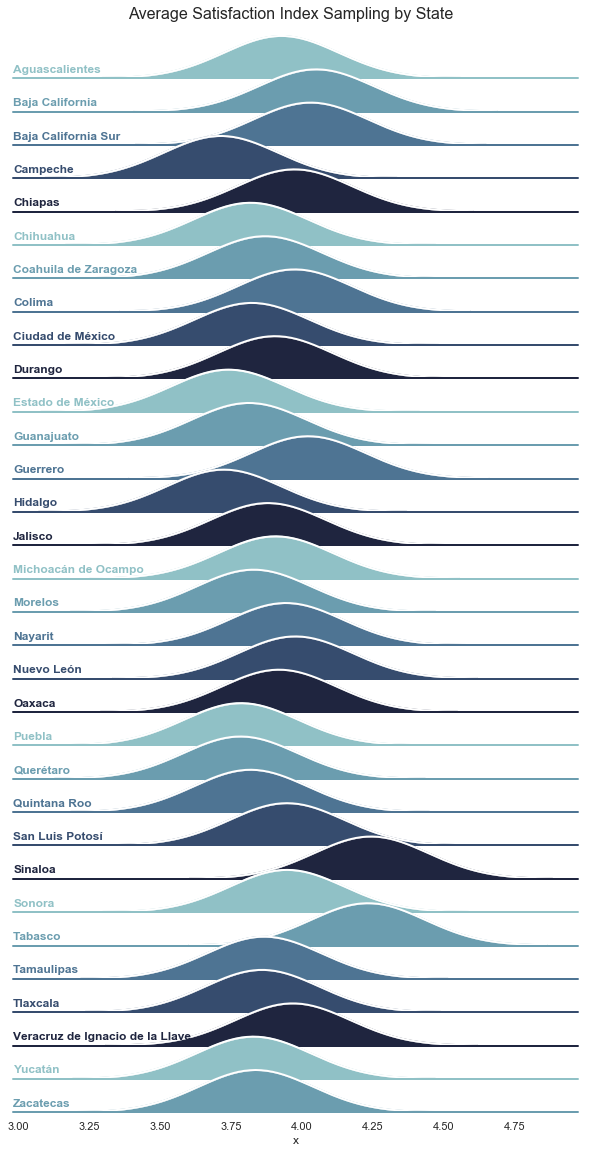

In [284]:
##Overlaping Densities
#Python source code: [download source: kde_ridgeplot.py]

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

#Create the data
x = list(dataEnt.Av17)
g = list(dataEnt.Entidad)
df= pd.DataFrame({"x":x,"g":g})
#m = df.g.map(ord)
#df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=17, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.suptitle('Average Satisfaction Index Sampling by State', fontsize=16, y=1)
plt.savefig('DataExploring\overlapStateAvSamples.png',dpi=1200)
plt.show()

# Correlation with Satisfaction

In [328]:
df7=df6[['Sat1_ordered',
         'Citapre',
         'Diascita',
         'Hrcita',
         'Tmesphoci',
         'Satiemhoci',
         'Tmedreg2',
         'Satiemesp',
         'Temsad1',
         'Temsad2',
         'Recmedhoy',
         'Filtrofarm2',
         'Totmed',
         'Btratou',
         'Escolar',
         'Calfinmb_F',
         'Edad',
         'Edad_C',
         'Fecha_A',
         'Entidad']]

In [329]:
df7.head()

,Sat1_ordered,Citapre,Diascita,Hrcita,Tmesphoci,Satiemhoci,Tmedreg2,Satiemesp,Temsad1,Temsad2,Recmedhoy,Filtrofarm2,Totmed,Btratou,Escolar,Calfinmb_F,Edad,Edad_C,Fecha_A,Entidad
0,5.0,1,4.0,1.0,NaN,NaN,1,2.0,3.0,NaN,1,1.0,1.0,2,5,1,29.0,NaN,2018,Aguascalientes
1,4.0,1,4.0,1.0,NaN,NaN,1,1.0,1.0,NaN,1,1.0,1.0,2,9,3,45.0,NaN,2018,Aguascalientes
2,5.0,1,4.0,1.0,NaN,NaN,2,1.0,NaN,NaN,1,1.0,1.0,1,9,2,80.0,NaN,2018,Aguascalientes
3,5.0,1,4.0,1.0,NaN,NaN,1,1.0,NaN,NaN,1,1.0,1.0,1,5,3,73.0,NaN,2018,Aguascalientes
4,5.0,1,4.0,1.0,NaN,NaN,1,1.0,NaN,NaN,1,1.0,1.0,2,7,1,60.0,NaN,2018,Aguascalientes


In [330]:
# the less the time the appointment is required to happen it has a higher puntuaction

df7['Diascita_ord']=df7.Diascita.map({1:'6',
                                      2:'5',
                                      3:'4',
                                      4:'3',
                                      5:'2',
                                      5:'1',
                                      99:np.nan})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [331]:
df7['Citapre_ord']=df7.Citapre.map({1:1,
                                    2:0,
                                    99:np.nan})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [332]:
df7['Hrcita_ord']=df7.Hrcita.map({1:3,
                                  2:2,
                                  3:1,
                                  99:np.nan})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [333]:
df7['Tmesphoci_ord']=df7.Tmesphoci.map({1:6,
                                        2:5,
                                        3:4,
                                        4:3,
                                        5:2,
                                        6:1,
                                        99:np.nan})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [334]:
df7['Satiemhoci_ord']=df7.Satiemhoci.map({1:5,
                                          2:4,
                                          3:3,
                                          4:2,
                                          5:1,
                                          99:np.nan})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [335]:
# Lower wating times have higher index

df7['Tmedreg2_ord']=df7.Tmedreg2.map({1:6,
                                      2:5,
                                      3:4,
                                      4:3,
                                      5:2,
                                      6:1,
                                      99:np.nan})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [336]:
df7['Satiemesp_ord']=df7.Satiemesp.map({1:5,
                                    2:4,
                                    3:3,
                                    4:2,
                                    5:1,
                                    99:np.nan})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [337]:
df7['Temsad1_ord']=df7.Temsad1.map({1:7,
                                    2:6,
                                    3:5,
                                    4:4,
                                    5:3,
                                    6:2,
                                    7:1,
                                    99:np.nan})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [338]:



df7['Temsad2_ord']=df7.Temsad2.map({1:7,
                                    2:6,
                                    3:5,
                                    4:4,
                                    5:3,
                                    6:2,
                                    7:1,
                                    99:np.nan})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [339]:
df7['Totmed_ord']=df7.Totmed.map({1:3,
                              2:2,
                              3:1,
                              99:np.nan
                             })

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [340]:
df7['Btratou_ord']=df7.Btratou.map({1:5,
                                2:4,
                                3:3,
                                4:2,
                                5:1,
                                99:np.nan})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [341]:
df7['Calfinmb_F_ord']=df7.Calfinmb_F.map({1:5,
                                      2:4,
                                      3:3,
                                      4:2,
                                      5:1,
                                      99:np.nan})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [342]:
df7.columns

Index(['Sat1_ordered', 'Citapre', 'Diascita', 'Hrcita', 'Tmesphoci',
       'Satiemhoci', 'Tmedreg2', 'Satiemesp', 'Temsad1', 'Temsad2',
       'Recmedhoy', 'Filtrofarm2', 'Totmed', 'Btratou', 'Escolar',
       'Calfinmb_F', 'Edad', 'Edad_C', 'Fecha_A', 'Entidad', 'Diascita_ord',
       'Citapre_ord', 'Hrcita_ord', 'Tmesphoci_ord', 'Satiemhoci_ord',
       'Tmedreg2_ord', 'Satiemesp_ord', 'Temsad1_ord', 'Temsad2_ord',
       'Totmed_ord', 'Btratou_ord', 'Calfinmb_F_ord'],
      dtype='object')

In [349]:
df8=pd.DataFrame({'Satisfaccion':df7['Sat1_ordered'],
                  'diasParaCita':df7['Diascita_ord'],
                  'citaPrevia':df7['Citapre_ord'],
                  'citaPuntual':df7['Hrcita_ord'],
                  'tiempoEspCitaIndex':df7['Tmesphoci_ord'],
                  'satTmpoEspllegada':df7['Satiemesp_ord'],
                  'tmpoEspLlegIndex':df7['Tmedreg2_ord'],
                  'tmpoEspLabIndex':df7['Temsad1_ord'],
                  'tmpoEspEstudiosIndex':df7['Temsad2_ord'],
                  'encontroMedIndex':df7['Totmed_ord'],
                  'tratoIndex':df7['Btratou_ord'],
                  'limpiezaIndex':df7['Calfinmb_F_ord'],              
                  'Edad':df7['Edad'],
                  'Año':df7['Fecha_A']
                   })

In [358]:
correlations=df8.corr()

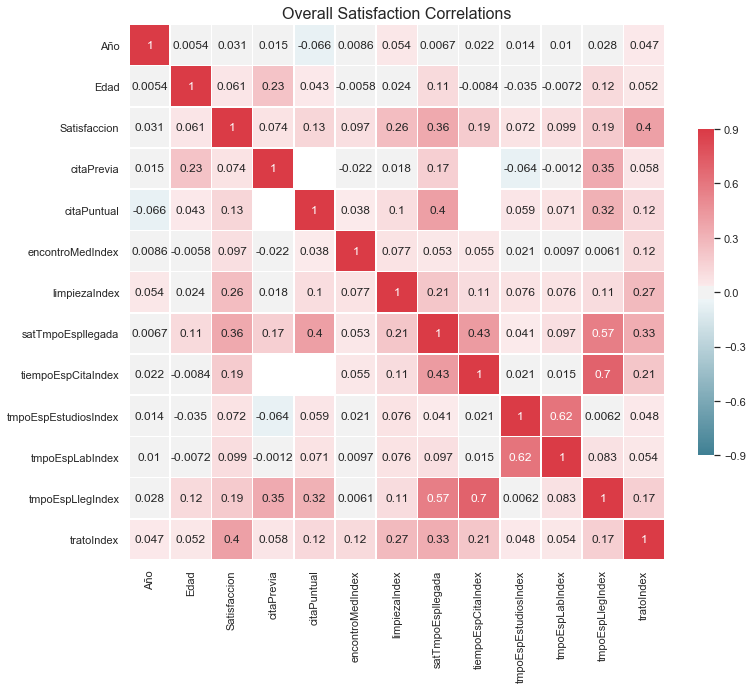

In [363]:
sns.set(style="white")

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Make the figsize 20 x 20
plt.figure(figsize=(12,12))

# Plot heatmap of correlations
ax=sns.heatmap(correlations,annot=True,cmap=cmap, vmax=.9,vmin=-.9, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Overall Satisfaction Correlations',fontsize=16)

plt.show()

In [354]:
correlations18=df8[df8['Año']==2018].corr()

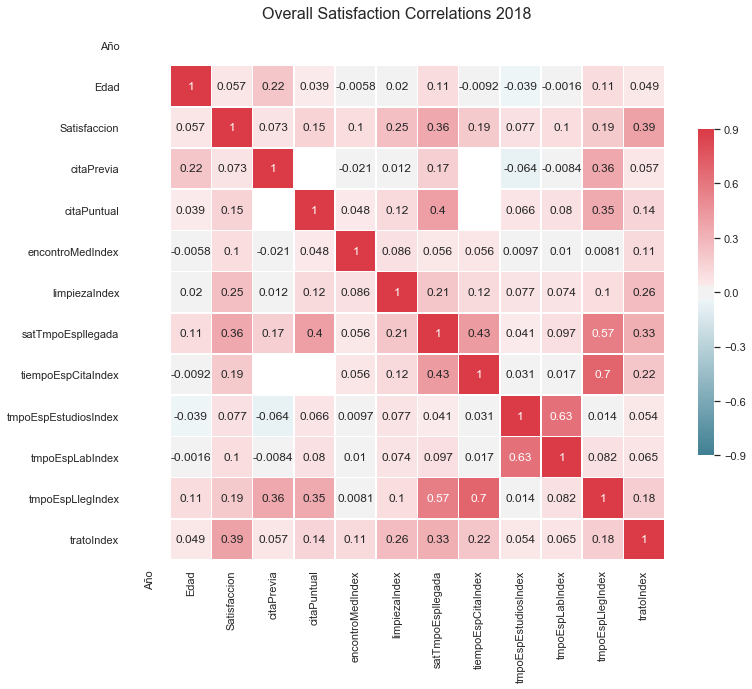

In [364]:
sns.set(style="white")

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Make the figsize 20 x 20
plt.figure(figsize=(12,12))

# Plot heatmap of correlations
ax=sns.heatmap(correlations18,annot=True,cmap=cmap, vmax=.9,vmin=-.9, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Overall Satisfaction Correlations 2018',fontsize=16)


plt.show()

In [356]:
correlations17=df8[df8['Año']==2017].corr()

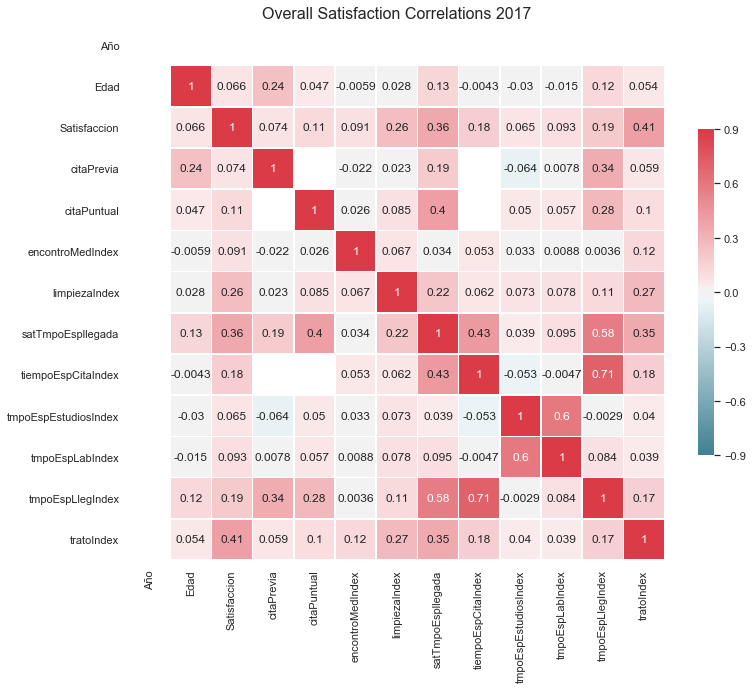

In [365]:
sns.set(style="white")

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Make the figsize 20 x 20
plt.figure(figsize=(12,12))

# Plot heatmap of correlations
ax=sns.heatmap(correlations17,annot=True,cmap=cmap, vmax=.9,vmin=-.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Overall Satisfaction Correlations 2017',fontsize=16)

plt.show()

In [371]:
corr17vs18=pd.DataFrame({'2017':correlations17['Satisfaccion'],
                         '2018':correlations18['Satisfaccion']
                        })

In [375]:
corr17vs18['Variacion%']=((corr17vs18['2018']-corr17vs18['2017'])/corr17vs18['2017'])*100

In [376]:
corr17vs18

,2017,2018,Variacion%
Año,NaN,NaN,NaN
Edad,0.065502,0.057020,-12.948361
Satisfaccion,1.000000,1.000000,0.000000
citaPrevia,0.073612,0.072842,-1.045500
citaPuntual,0.114457,0.150551,31.534893
encontroMedIndex,0.091072,0.101925,11.916228
limpiezaIndex,0.257708,0.251845,-2.275021
satTmpoEspllegada,0.363753,0.355675,-2.220640
tiempoEspCitaIndex,0.176125,0.190387,8.097573
tmpoEspEstudiosIndex,0.065006,0.077391,19.052458
